In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import src.utils.data_utils as data_utils

# Check if LaTeX is available, if not we don't import the plot_config module
latex_available = False
try:
    plt.rcParams['text.usetex'] = True
    plt.text(0, 0, "Test", fontsize=12)
    latex_available = True
    plt.close()
except Exception as e:
    print("LaTeX is not available. Error:", e)
finally:
    plt.rcParams['text.usetex'] = False

# Import the plot_config module if LaTeX is available
if latex_available:
    import src.utils.plot_config

%matplotlib inline

In [2]:
# Download the data files
datasets = [ 
    # ("https://zenodo.org/records/4650046/files/_raw_df_channels.tsv.gz?download=1", "channels.tsv.gz"), # 6.0 MB
    # ("https://zenodo.org/records/4650046/files/yt_metadata_en.jsonl.gz?download=1", "yt_metadata.jsonl.gz"), # 13.6 GB
]

data_utils.get_data(datasets)

In [80]:
# Open and read the file
df_video_counts = pd.read_json('data/video_counts.jsonl.gz', lines=True, compression='gzip')
df_video_counts.sample(3)

,channel_id,video_count
100347,UCCguLHpJgJ9wbNkt76M99Bw,189
25364,UChOGGwrkhB0EGk7_MtvMkPA,261
57705,UCUcfnbAMtbAZC7Xkdci3g5Q,250


# Classification using keywords

## Chunk Processing

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

The following cell tests the `preprocess_collaborations` function (defined in data_utils.py).



**Comment on methodology:** 
- The detection of collaborations is based on the presence of specific keywords in the video title, by default the keywords are:`feat`, `ft`, `featuring`, `x`, `w/`, `ft.`.
- This approach is really simple and may not be accurate in all cases. We could have considered other keywords such as `with`, `and`, `&`, etc. but this would yield a greater number of false positives (this has been tested). 
- With this approach, we may have many false negatives, i.e. collaborations that are not detected.
- We also tested the detection of collaborations using a zero-shot model (see the cell at the end of this notebook). This approach revealed that the zero-shot model is not accurate enough to be used in this context (and it is also much slower).

</div>

In [3]:
# Load a chunk of data
data_file = 'data/yt_metadata.jsonl.gz'
test_data = pd.read_json(data_file, lines=True, compression="gzip", nrows=100_000)

# Preprocess the data
processed_df = data_utils.preprocess_collaborations(test_data)
processed_df.sample(3)

,categories,title,description,tags,view_count,like_count,dislike_count,channel_id,upload_date
13840,Entertainment,Main Course 73 (feat. SDCC 2013 warm up),A.C.B.A. Merchandise site:\nhttp://shop.articu...,"A.C.B.A.,Articulated Comic Book Art,Collectibl...",2038,85.0,3.0,UCzVt21g9aCG6EM5hgTtQjeQ,2013-07-17 00:00:00
34455,Music,Red Swan (Attack on Titan Season 3 OP) - Yoshi...,"The world is merciless, and it's also very bea...","piano tutorial,sheet music boss,red swan,attac...",59419,2557.0,27.0,UCzTR9iSH-TFC4-ocDS_ll4A,2019-06-03 00:00:00
44195,Music,Plus Baby ft. PDibiase - See | Shot By @Dinero...,https://soundcloud.com/aye-scud/see-prod-by-tr...,"plus,plus baby,pdibiase,see,aye scud,scud nation",5689,167.0,53.0,UCzTC4m1jBXd4NwNqLdrzmNA,2015-03-29 00:00:00


## Process the whole dataset

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

The following cells process the whole dataset and saves the results to new files.

This should be done only once, as it may take a long time to run.

</div>

In [4]:
# Define the input and output paths
data_file = 'data/yt_metadata.jsonl.gz'
output_path = 'data/collaborations.jsonl.gz'
chunk_size = 100_000

In [5]:
# Process the collaboration data (this may take ~30 minutes) 
# data_utils.process_data(data_file, chunk_size, preprocess_collaborations, output_path)

In [ ]:
# Process the number of videos per channel_id
# data_utils.process_video_counts(data_file, chunk_size, output_path='data/video_counts.jsonl.gz')

## Open the processed data

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

In the cells below, we open the processed data and display the first few rows. Then, we display the number of collaborations in each category.

In previous analysis, we found that the total number of Music videos is ~ 8.2 M and the total number of Entertainment videos is ~ 12.3 M, we can therefore compare the fraction of collaborations in each category. 
</div>

In [6]:
# Load the processed data and display the first few rows
df_collaborations = pd.read_json('data/collaborations.jsonl.gz', lines=True, compression='gzip')
df_collaborations.sample(3)

,categories,title,description,tags,view_count,like_count,dislike_count,channel_id,upload_date
307436,Music,S Loc x Hypa x Murda - Closer (CUT BY M WORKS),"S Loc, Hypa and Murda starring in ""Closer"" off...","closer,s loc,hypa,murda,honest,deeper than the...",54083,490,103,UCxI3FOo1_SU6_UPBMhxTHwA,2017-06-08 00:00:00
763868,Music,"[SOLD] Amine X Noname Type Beat 2018 - ""PARIS""...",new wave.\n\n\n●🔥Let's hit 10k! Subscribe Now!...,"Amine Type Beat,Amine Type Beat 2018,Free Amin...",711053,17852,126,UC88Wq7tg0ei3FyOXweotcew,2018-04-06 00:00:00
867408,Music,ICYTWAT - Can't Afford Me Feat. Cyrax (Win32 R...,[Trap - Vocals]\n\nFire!\n\nWin32\nhttps://sou...,"ICYTWAT,Affor,Can't Afford me,Cyrax,Feat,Win32...",1052,26,2,UCtrHcoiynEEILOrqtGAC1Aw,2016-07-01 00:00:00


In [16]:
# Display the number of collaborations in each category
counts = df_collaborations.value_counts('categories')
print(f"Fraction of collaborations in the Music category: {100 * counts['Music'] / 8.2e6:.1f} %")
print(f"Fraction of collaborations in the Entertainment category: {100 * counts['Entertainment'] / 12.3e6:.1f} %")

Fraction of collaborations in the Music category: 8.6 %
Fraction of collaborations in the Entertainment category: 1.8 %


<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Comment:** with our collaboration detection technique, there are more collaborations in the Music category compared to the Entertainment category.

</div>

In [81]:
df_video_counts = pd.read_json('data/video_counts.jsonl.gz', lines=True, compression='gzip')
df_video_counts.sample(3)

,channel_id,video_count
6460,UCpN9tj3DOoOiPfMyNMBAGdw,165
70627,UCOzCasv5QbALvWOeDtsAUZA,101
30269,UCf2ocK7dG_WFUgtDtrKR4rw,2612


## Are collaborations more prone to greater viewership and engagement? 

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

We can start by studying the distribution of the number of views, likes, and dislikes for collaborations in each category.

We can then 
1. Compare the distributions for collaborations between the Music and Entertainment categories.
2. Compare the distributions for collaborations and non-collaborations in each category. 

Point 1. will help us understand if one category has the upper hand when it comes to collaborations. 

Point 2. will help us understand if collaborations are more successful than non-collaborations in each category.

</div>

In [17]:
# We start by creating a dataframe per category
df_music = df_collaborations[df_collaborations['categories'] == 'Music'].copy()
df_entertainment = df_collaborations[df_collaborations['categories'] == 'Entertainment'].copy()

In [18]:
df_music.sample(3)

,categories,title,description,tags,view_count,like_count,dislike_count,channel_id,upload_date
525254,Music,R-Wan ft. Fatman Scoop - On The Ground (Lyric ...,LNG is Australia's premier music label - produ...,"LNG music,dance music,music,playlists,dance,tr...",544,9,1,UCMe5TnYyF0whwivOXhHB8VA,2018-06-14 00:00:00
861469,Music,Grandtime Riddim Mix [Jan 2019] feat. Busy Sig...,Grandtime Riddim Mix produced by Bulpus Produc...,"Circle Sound,Reggae,Dancehall,Riddim,Mix,Grand...",821,22,1,UC2Cmin2AChDSOSueQO24nRA,2019-01-27 00:00:00
492252,Music,Mozzy X E Mozzy X JuneOnnaBeat Type Beat,86BPM,"mozzy,mozeralla,new,music,flp,download,mp,slap...",2885,70,1,UCOQi_wQpfGe6P47lfjp-s0w,2018-02-17 00:00:00


In [19]:
df_entertainment.sample(3)

,categories,title,description,tags,view_count,like_count,dislike_count,channel_id,upload_date
364397,Entertainment,हासेर बोल न नानी - Nepali Lok dohori By RK Gur...,Hasera Bola Na Nani - Nepali Lok dohori By RK ...,"rk guung,rupa gharti magar,live in uk,lok geet...",15127,113,7,UCX6LflSUem806jOV4y-zVYg,2017-12-17 00:00:00
245087,Entertainment,21 Savage Ft. J. Cole - A Lot (Reaction Video),LIKE | COMMENT | SHARE | SUBSCRIBE\n\nContact ...,"new,reaction,videos,reacts,funny,lv,skinny,rea...",3146,109,3,UCdsk_SJwAZKysvEv1nIWbkQ,2018-12-27 00:00:00
655346,Entertainment,Softly does it for Misha B - The X Factor 201...,The X Factor: She's got soul has Misha B and t...,"The,Factor,the x factor,x factor,simon cowell,...",80188,757,120,UCEY1ejsweY4DgMwOVJeEaBA,2011-11-26 00:00:00


### Distribution of views, likes, and dislikes for Music and Entertainment collaborations

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

We start by plotting the distribution of views, likes, and dislikes for the Music and Entertainment categories separately.

(Uncomment the cell below to run it, the results are directly compared below).

</div>

In [20]:
# Distributions for the Music category
# data_utils.plot_category_distribution(df_data=df_music,
#                                       columns=["view_count", "like_count", "dislike_count"],
#                                       category="Music",
#                                       x_logs=[True, True, True],
#                                       y_logs=[False, False, True],
#                                       kind="hist",
#                                       print_summary=True)

In [21]:
# Distributions for the Entertainment category
# data_utils.plot_category_distribution(df_data=df_entertainment,
#                                       columns=["view_count", "like_count", "dislike_count"],
#                                       category="Entertainment",
#                                       x_logs=[True, True, True],
#                                       y_logs=[False, False, True],
#                                       kind="hist",
#                                       print_summary=True)

### Comparison of views, likes, and dislikes between Music and Entertainment collaborations

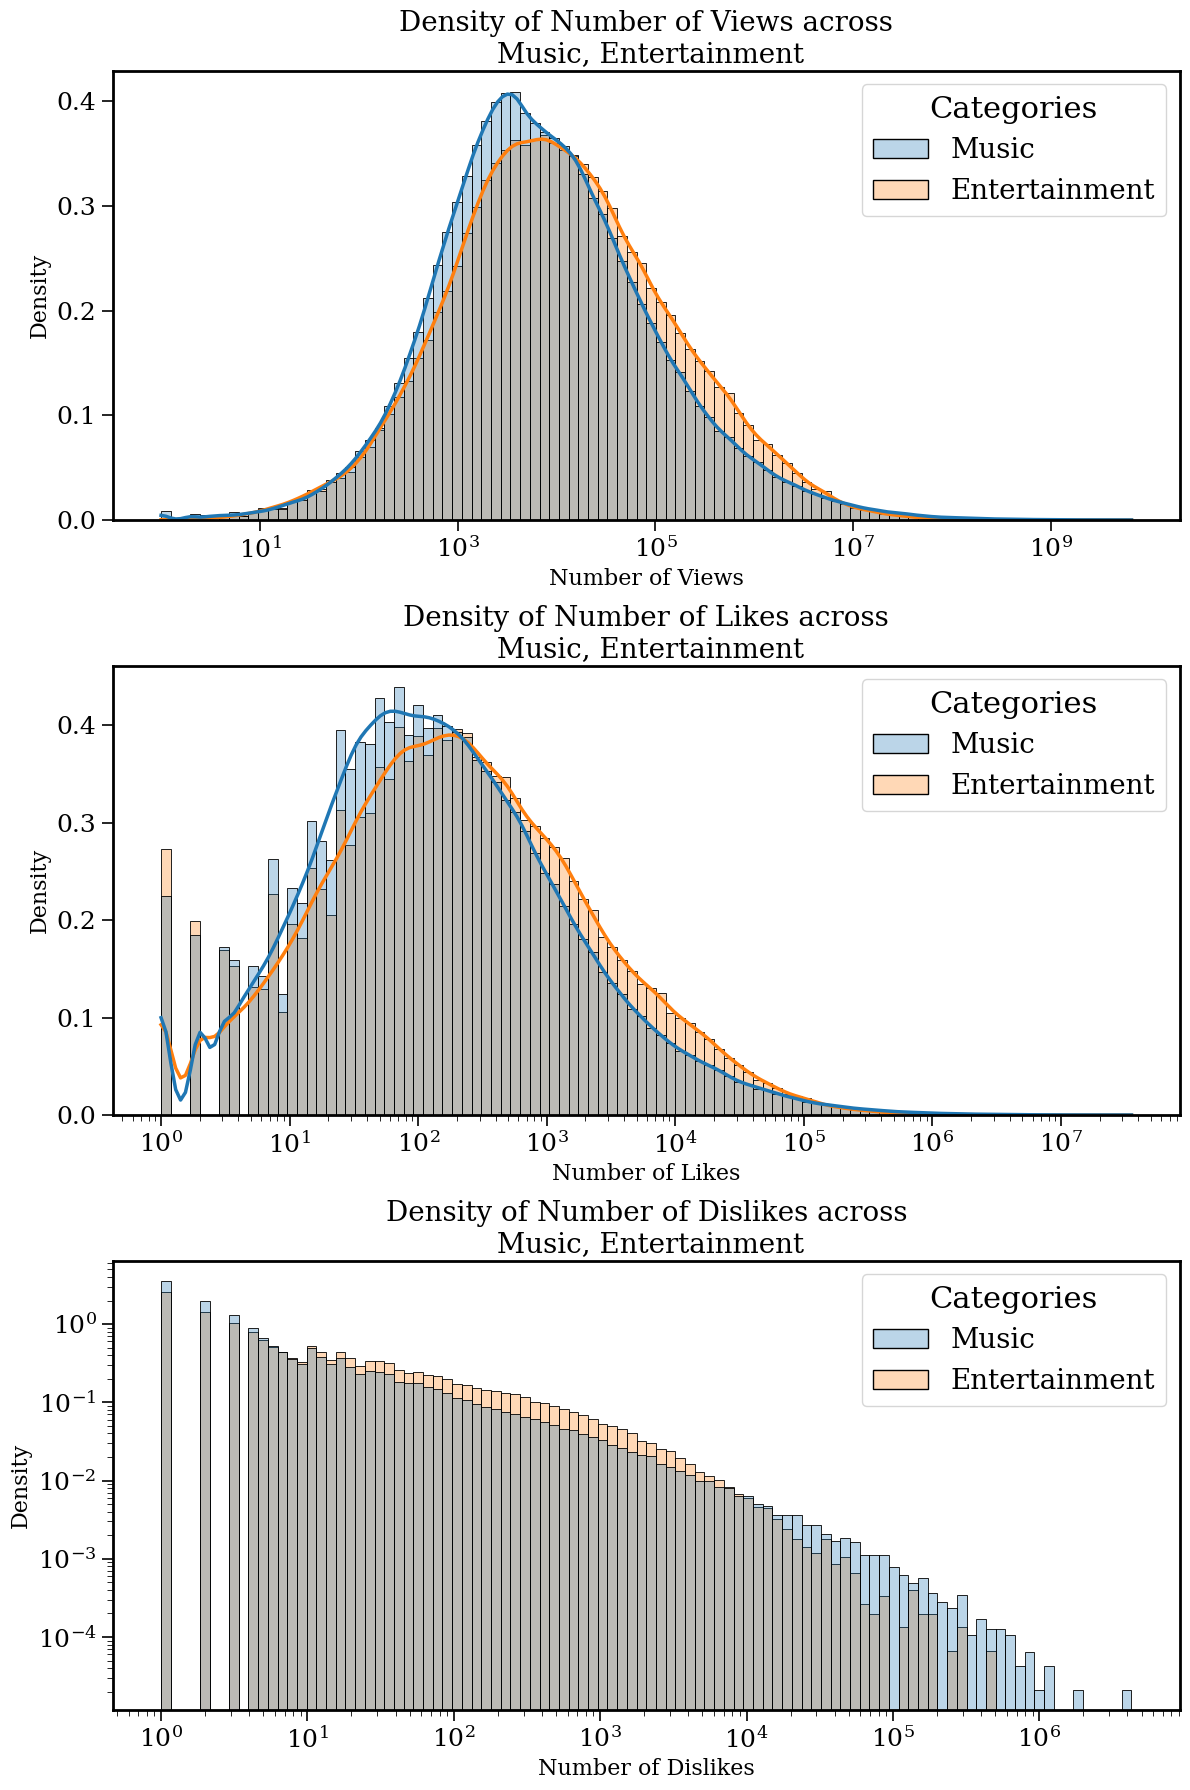

In [22]:
categories = ["Music", "Entertainment"]
data_utils.compare_distribution_across_categories(df_collaborations,
                                                  columns=["view_count", "like_count", "dislike_count"],
                                                  categories=categories,
                                                  hue="categories",
                                                  x_logs=[True, True, True],
                                                  y_logs=[False, False, True],
                                                  kind="hist",
                                                  marker_only=False, 
                                                  density=True)

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Some comments:**

- The distribution of views for the Music category seems to be slightly skewed to the left compared to the Entertainment category. 

- A similar observation can be made for the distribution of likes. 

- The distribution of dislikes seems almost power-law distributed for the Music category. The Entertainment distribution is a bit more "rounded". 

In each case, since we log-transformed the x-axis, we can look at the geometric mean to compare the two categories.

</div>

In [23]:
# Compute both geometric and arithmetic means for each category
columns = ["view_count", "like_count", "dislike_count"]

music_gmeans = {col: data_utils.geometric_mean(df_music[col]) for col in columns}
entertainment_gmeans = {col: data_utils.geometric_mean(df_entertainment[col]) for col in columns}

music_means = {col: df_music[col].mean() for col in columns}
entertainment_means = {col: df_entertainment[col].mean() for col in columns}

# Display the comparison in a unified table
print("Comparison of geometric and arithmetic Means for Music and Entertainment Categories:\n")
print(f"{'Metric':<20} {'Music (Geometric)':<20} {'Entertainment (Geometric)':<30} {'Music (Arithmetic)':<20} {'Entertainment (Arithmetic)':<20}")
print("-" * 120)

for col in columns:
    music_geo = music_gmeans[col]
    music_arith = music_means[col]
    ent_geo = entertainment_gmeans[col]
    ent_arith = entertainment_means[col]
    print(f"{col:<20} {music_geo:<20.2f} {ent_geo:<30.2f} {music_arith:<20.2f} {ent_arith:<20.2f}")

Comparison of geometric and arithmetic Means for Music and Entertainment Categories:

Metric               Music (Geometric)    Entertainment (Geometric)      Music (Arithmetic)   Entertainment (Arithmetic)
------------------------------------------------------------------------------------------------------------------------
view_count           7716.97              10885.06                       681441.02            311771.52           
like_count           145.24               194.23                         5114.49              3640.42             
dislike_count        6.58                 10.81                          228.10               166.95              


<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

**Some comments**

- When looking at the geometric means, the Entertainment category seems to have the upper hand in terms of views and likes (as can be seen from the distributions).
- Interestingly, when looking at the arithmetic means (that might be ill-defined), the Music category seems to have higher values for views and likes. This is probably due to the presence of **stronger outliers in the Music category**. 

</div>

## Do creators that make both music and entertainment content have more collaborations?

In [25]:
music_creators = df_music['channel_id'].unique()
entertainment_creators = df_entertainment['channel_id'].unique()
common_creators = set(music_creators).intersection(set(entertainment_creators))

print(f"Number of unique creators in the Music category: {len(music_creators)}")
print(f"Number of unique creators in the Entertainment category: {len(entertainment_creators)}")
print(f"Number of creators in common between the Music and Entertainment categories: {len(common_creators)}")

Number of unique creators in the Music category: 22296
Number of unique creators in the Entertainment category: 18368
Number of creators in common between the Music and Entertainment categories: 3698


## Is there a correlation between the number of collaborations and a channel success? 

<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

1. We can start by grouping the data by `channel_id` and counting the number of collaborations for each channel. 
2. Then, we merge the collaboration dataframe with the video_counts dataframe
3. Then, we can merge this data with the channels data to associate the `channel_id` with the `channel name`. 
    - But we should be careful here: **there are only channels with more than 10k subscribers in the channels data**. This means that some `channels_id` won't be associated with a channel name. 

</div>

In [75]:
# 1. 
# Add a new column to the collaborations data that counts the number of collaborations for each channel
df_collaborations['collaborations_count'] = df_collaborations.groupby('channel_id')['channel_id'].transform('count')

print(f"Number of unique channels in the collaborations data: {df_collaborations['channel_id'].nunique()}")
df_collaborations.sample(3)

Number of unique channels in the collaborations data: 36966


,categories,title,description,tags,view_count,like_count,dislike_count,channel_id,upload_date,collaborations_count,videos_cc
917333,Music,"Mark Ski ""Sloppy Drunk (feat Tenacity) (Explic...",,"01,Sloppy,Drunk,(feat,Tenacity),(Explicit)",20,2,0,UCtAayeNiekDvujWk_cfSD6A,2019-04-25 00:00:00,2155,2155
811305,Music,JP Bacallan - HALIKANA (feat. Pricetagg),Written & Performed by JP Bacallan & Pricetagg...,"#HALIKANA,JP Bacallan,Pricetagg,Rawstarr,Mark ...",35484,483,10,UC5ikrol18Q6F0nnLpm3u-dA,2019-02-14 00:00:00,11,11
614851,Music,tyDi - Give Ourselves Away (feat. Khaz),Taken from tyDi's brand new studio album #REDE...,"tyDi,EDM,Electro,DJ,tydidj,tydilyrics,tydirede...",15686,79,5,UCGrtg6XOFG1oFd-kfNeSfYw,2014-11-23 00:00:00,63,63


In [82]:
# 2. 
# Merge the collaborations data with the video counts data
df_collaborations = pd.merge(df_collaborations, df_video_counts, on='channel_id', how='left')
df_collaborations.sample(3)

,categories,title,description,tags,view_count,like_count,dislike_count,channel_id,upload_date,collaborations_count,videos_cc,video_count
905324,Music,Garth Garcia | Real Love feat. Q York | Music ...,Garth Garcia | Real Love feat. Q York | Music ...,"OPM,garth garcia,Q York,york,real love,real,lo...",408,6,1,UC-41daFrBBou8CAoaa7_6Ig,2018-10-23 00:00:00,41,41,1294
770210,Music,DIAVO x DAVID x ModWuk - Eyri [Official Video],Slušajte na digitalnim platformama: 👍👍👍\n\nhtt...,"rap,rep,trap,rep muzika,diavo,Mascom,mascom,hi...",141503,807,31,UC7fLeEWbUOq6y9cbpTut2kg,2019-05-31 00:00:00,26,26,384
820279,Music,Re-Style feat. Mercenary - Going Down (HQ PREV...,OUT NOW! http://www.hardtunes.com/albums/re-st...,"Re,Style,Mercenary,Going,Down,VIDEO",11609,90,2,UC5-p6UtFN5_buV55ouMTCKQ,2011-09-26 00:00:00,18,18,103


In [51]:
# 3. 
# Open the channels data, filter the Music and Entertainment categories, and drop the join_date column
df_channels = pd.read_csv('data/channels.tsv.gz', sep='\t', compression='gzip')
df_channels = df_channels[df_channels['category_cc'].isin(['Music', 'Entertainment'])]
df_channels = df_channels.drop(columns=['join_date', 'category_cc'], axis=1)
df_channels = df_channels.rename(columns={'channel': 'channel_id'})

print(f"Number of unique channels in the Entertainment and Music categories: {df_channels.shape[0]}")

# Merge the channel names to the collaborations data
df = pd.merge(df_collaborations, df_channels, on='channel_id', how='left')

# Create a new column that calculates the ratio of collaborations to the total number of videos
df['colab_ratio'] = df['collaborations_count'] / df['videos_cc']

# Reorder the columns
new_order = ['name_cc', 'title', 'view_count', 'like_count', 'dislike_count', 'description', 'tags', 'upload_date', 'subscribers_cc',
             'videos_cc', 'collaborations_count', 'colab_ratio', 'channel_id', 'categories']

df = df[new_order].copy()

Number of unique channels in the Entertainment and Music categories: 55513


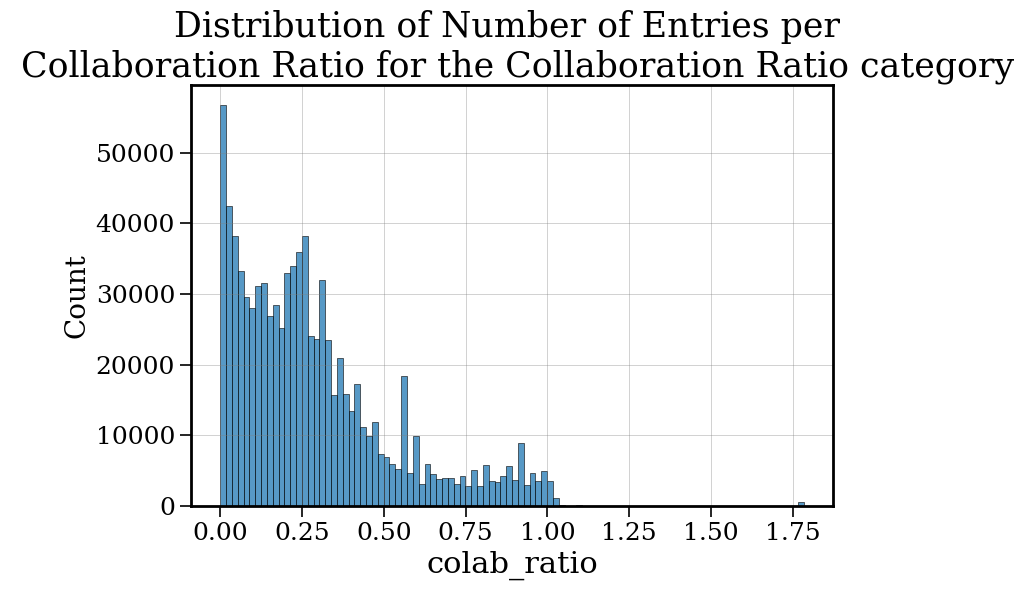

In [74]:
# Plot the distribution of the collaboration ratio
data_utils.plot_category_distribution(df_data=df,
                                      columns=["colab_ratio"],
                                      category="Collaboration Ratio",
                                      x_logs=[False],
                                      y_logs=[False],
                                      kind="hist",
                                      print_summary=False)

In [49]:
# counts the number of channels that have different categories and category_cc columns (i.e. channels that have both Music and Entertainment categories)
test_df = df[df['category_cc'] != df['categories']]
print(f"Number of channels with different categories: {test_df['channel_id'].nunique()}")

Number of channels with different categories: 10358


<div style="background-color: #D8EAD8; border-left:3px solid green; padding: 10px; border-radius: 5px;">

Quelques idées en vrac: 
- Regarder l'évolution du nombre de collaborations au fil du temps grâce à la colonne `upload_date`
- Corrélation entre chaîne plus connue et les collaborations. Est-ce qu'une chaîne qui fait souvent des collaborations également plus généralement connues?

</div>

# Classification using a Zero-Shot Model

In [21]:
# from transformers import pipeline
# 
# def is_significant(collab_score, non_collab_score, threshold=0.1):
#     """
#     Check if the difference between two scores is significant.
# 
#     Args:
#         collab_score (float): Score for the collaboration label.
#         non_collab_score (float): Score for the non-collaboration label.
#         threshold (float): Minimum difference to consider the scores significant.
# 
#     Returns:
#         bool: True if the scores are significant, False otherwise.
#     """
#     return abs(collab_score - non_collab_score) > threshold
# 
# 
# MODEL_PATH = 'src/models/zero-shot-classification'
# 
# # Load the zero-shot classification model
# classifier = pipeline("src/models/zero-shot-classification", model="facebook/bart-large-mnli")
# 
# # Save the model to disk
# model_path = "src/models/zero-shot-classification"
# classifier.save_pretrained(model_path)
# 
# # Labels for the zero-shot classification model
# music_collab_labels = ['multiple artists']
# music_non_collab_labels = ['a single artist']
# music_labels = music_collab_labels + music_non_collab_labels
# 
# # Hypothesis template for the zero-shot classification model
# music_hypothesis_template = "This music is with {}."
# 
# texts = ["Radiohead live at Glastonbury 2003",
#          "The Beatles - Hey Jude", 
#          "Best of Debussy",
#          "HAYATO SUMINO – third round (18th Chopin Competition, Warsaw)",
#          "LL COOL J - Murdergram Deux ft. Eminem", 
#          "Eminem - Love The Way You Lie ft. Rihanna"
#          ]
# 
# for text in texts:
#     result = classifier(
#         text,
#         candidate_labels=music_labels,
#         hypothesis_template=music_hypothesis_template,
#         multi_label=False,
#     )
# 
#     # Extract scores for collaboration and non-collaboration labels
#     collab_scores = np.array([score for label, score in zip(result['labels'], result['scores']) if label in music_collab_labels])
#     non_collab_scores = np.array([score for label, score in zip(result['labels'], result['scores']) if label in music_non_collab_labels])
# 
#     total_collab_score = collab_scores.sum()
#     total_non_collab_score = non_collab_scores.sum()
# 
#     # Check if the scores are significant
#     if is_significant(total_collab_score, total_non_collab_score, threshold=0.5):
#         # Décider de la catégorie basée sur le score maximal
#         if total_collab_score > total_non_collab_score:
#             prediction = "Collaborative"
#         else:
#             prediction = "Non-Collaborative"
#     else:
#         continue
# 
#     print(f"Text: {text}. "
#           f"\n    - Predicted category: {prediction}, "
#           f"\n    - collab_score: {total_collab_score}, "
#           f"\n    - non_collab_score: {total_non_collab_score}")